# Process gridded CMIP6 model data into timeseries

__1. Process the gridded temperature data into timeseries for each model.__

Output is a dataArray for each model with dimensions of time and IPCC region containing a time series of the TAS variable.


Use this tool:  

https://github.com/IPCC-WG1/Atlas/blob/main/notebooks/reference-regions_Python.ipynb

Nathan notes that these models do the best job in CONUS:  MPI-ESM, GFDL-ESM2M, CESM1-CAM5, CanESM2.

__I already have access to two of them.__

_Need to figure out access to CMIP6 model PI-Control simulations._  

- Emailed Marika  
- Could talk to Zhu  
- Could email Nicola

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

In [1]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask
    )

%matplotlib inline

__PI-Control Simulations.__  

Nicola/MPI: /glade/scratch/nmaher/mpi_jonah  

CESM1-LE: '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'


In [2]:
# mpi_pic_dir = '/glade/scratch/nmaher/mpi_jonah/'
cesm1_pic_dir   = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'
mpi_pic_dir     = '/glade/scratch/jonahshaw/CMIP5/MPI-GE/'
canesm2_pic_dir = '/glade/scratch/jonahshaw/CMIP5/CanESM2/'
esm2m_pic_dir   = '/glade/scratch/jonahshaw/CMIP5/GFDL-ESM2M/'

#### Collect CESM1 PIC file paths.

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

In [4]:
cesm1_pic_tas_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['tas']))
cesm1_pic_tas_files.sort()

cesm1_pic_ts_files = glob.glob('%s/%s/b.e11.B1850C5CN.f09_g16.005*.nc' % (cesm1_pic_dir,cesm1_cmor_var_dict['ts']))
cesm1_pic_ts_files.sort()

In [5]:
mpi_pic_tas_files = glob.glob('%s/*%s*.nc' % (mpi_pic_dir,'tas'))
mpi_pic_tas_files.sort()

mpi_pic_ts_files = glob.glob('%s/*%s*.nc' % (mpi_pic_dir,'ts'))
mpi_pic_ts_files.sort()

Organize file paths into a dictionary indexed by the variable.

In [6]:
lens_vars = ['tas','ts',]

cesm1_pic_path_dict = {
    'tas':cesm1_pic_tas_files,
    'ts' :cesm1_pic_ts_files,
}

mpi_pic_path_dict = {
    'tas':mpi_pic_tas_files,
    'ts' :mpi_pic_ts_files,
}

### Load a process timeseries according to IPCC Region designations.

#### 1. Visualize the IPCC AR6 regions

In [7]:
import regionmask

regionmask.__version__

'0.9.0'

In [8]:
import cartopy.crs as ccrs
import matplotlib.patheffects as pe

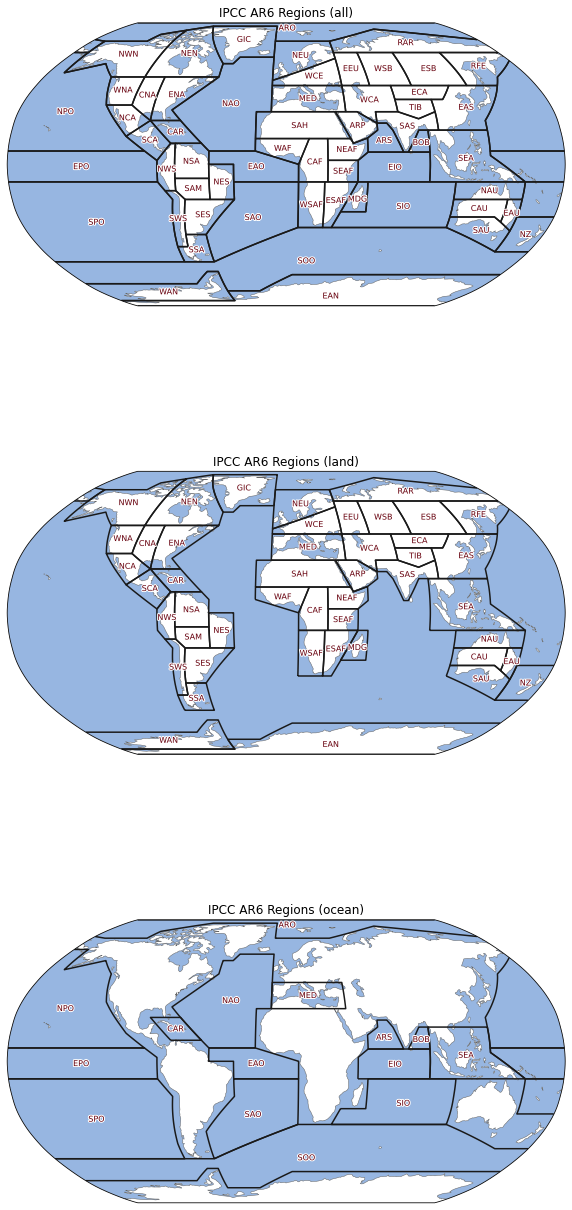

In [13]:
ipcc_ar6_regions_all   = regionmask.defined_regions.ar6.all
ipcc_ar6_regions_land  = regionmask.defined_regions.ar6.land
ipcc_ar6_regions_ocean = regionmask.defined_regions.ar6.ocean

text_kws = dict(
    bbox=dict(color="none"),
    path_effects=[pe.withStroke(linewidth=2, foreground="w")],
    color="#67000d",
    fontsize=8,
)

_fig,_axs = plt.subplots(3,1,figsize=(10,24),subplot_kw={'projection':ccrs.Robinson()})
_fig.subplots_adjust(hspace=0.1)

_axs[0].set_title('IPCC AR6 Regions (all)')
_axs[1].set_title('IPCC AR6 Regions (land)')
_axs[2].set_title('IPCC AR6 Regions (ocean)')

ax = ipcc_ar6_regions_all.plot(ax = _axs[0],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_land.plot(ax = _axs[1],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

ax = ipcc_ar6_regions_ocean.plot(ax = _axs[2],
    projection=ccrs.Robinson(), label="abbrev", add_ocean=True, resolution='110m', text_kws=text_kws
)
ax.set_global()

### 3. Do masking for a single file and region

CESM1-LE

In [9]:
ex_filepath = cesm1_pic_path_dict['tas'][0]

ex_tas_ds = xr.open_dataset(ex_filepath)

In [10]:
ex_tas_da = ex_tas_ds[cesm1_cmor_var_dict['tas']] #['TS']

MPI-GE

In [11]:
ex_mpi_filepath = mpi_pic_path_dict['tas'][0]

ex_mpi_tas_ds = xr.open_dataset(ex_mpi_filepath)

ex_mpi_tas_ds = ex_mpi_tas_ds['tas'].drop('height')

In [12]:
mpi_lats = np.linspace(-88.57,88.57,96)
mpi_lons = np.linspace(0,358.125,192)

In [13]:
# Everything is within 0.05 of a degree
print(((mpi_lats - ex_mpi_tas_ds['lat']) < 0.05).all())

print(((mpi_lons - ex_mpi_tas_ds['lon']) < 0.05).all())

<xarray.DataArray 'lat' ()>
array(True)
<xarray.DataArray 'lon' ()>
array(True)


In [26]:
# Check that my approximation of the coordinates is within 1% relative tolerances and 0.05 deg
np.testing.assert_allclose(mpi_lats,ex_mpi_tas_ds['lat'],atol=5e-2,rtol=1e-1)
np.testing.assert_allclose(mpi_lons,ex_mpi_tas_ds['lon'],atol=5e-2,rtol=1e-1)

Create mask.

In [14]:
regionmask.defined_regions.ar6.land

<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)
overlap:  False

Regions:
  0  GIC  Greenland/Iceland
  1  NWN  N.W.North-America
  2  NEN  N.E.North-America
  3  WNA    W.North-America
  4  CNA    C.North-America
..   ...                ...
 41  EAU        E.Australia
 42  SAU        S.Australia
 43   NZ        New-Zealand
 44  EAN       E.Antarctica
 45  WAN       W.Antarctica

[46 regions]

In [15]:
mask = regionmask.defined_regions.ar6.land.mask(ex_tas_da)

In [16]:
mask_fake = regionmask.defined_regions.ar6.land.mask(mpi_lons,mpi_lats)

In [ ]:
# mask_mpi = regionmask.defined_regions.ar6.land.mask(ex_mpi_tas_ds) # kills the kernel!

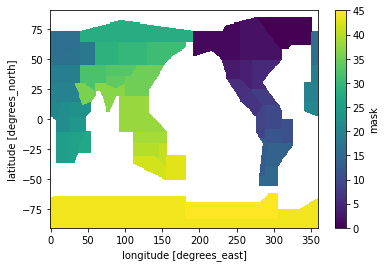

In [18]:
mask.plot()

In [16]:
mask

<xarray.DataArray 'mask' (lat: 192, lon: 288)>
array([[44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       [44., 44., 44., ..., 44., 44., 44.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

Oh cool! The mask has the value corresponding to the region's index?

In [17]:
# for colorbar: find abbreviations of all regions that were selected
reg = np.unique(mask.values)
reg = reg[~np.isnan(reg)]
abbrevs = regionmask.defined_regions.ar6.land[reg].abbrevs
names   = regionmask.defined_regions.ar6.land[reg].names

The CNA (central north america) region is index 4.

In [18]:
CNA_index = regionmask.defined_regions.ar6.land.map_keys("C.North-America")

In [19]:
# Mask out (in) a region
airtemps_CNA = ex_tas_da.where(mask == CNA_index)

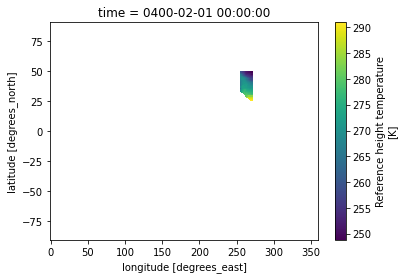

In [20]:
airtemps_CNA.isel(time=0).plot()

In [21]:
weights = np.cos(np.deg2rad(airtemps_CNA.lat))

ts_airtemps_CNA = airtemps_CNA.weighted(weights).mean(dim=("lat", "lon")) - 273.15

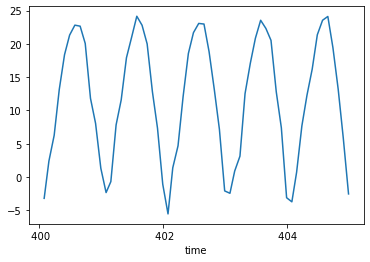

In [22]:
ts_airtemps_CNA.isel(time=slice(None,60)).plot()

### Write a function to compute timeseries for all IPCC AR6 regions when given a simple model output file.

In [23]:
# Filepath to a netcdf dataset.
_ds_filepath = cesm1_pic_path_dict['tas'][0]

# Variable to select and operate over.
_ds_var = cesm1_cmor_var_dict['tas']

In [24]:
def create_ipccregion_timeseries(_ds_filepath:str,_ds_var:str,regions:regionmask.Regions):
    
    '''
    Compute timeseries for all IPCC AR6 regions when given a simple model output file.
    '''

    # Load data
    ds      = xr.open_dataset(_ds_filepath,chunks={'lat':-1,'lon':-1}) 
    da      = ds[_ds_var]
    
    # Generate mask
    mask    = regions.mask(da)
    
    # Get unique region indices
    reg     = np.unique(mask.values)
    reg     = reg[~np.isnan(reg)]
    
    # for metadata: find abbreviations of all regions that were selected
    abbrevs = regions[reg].abbrevs
    names   = regions[reg].names
    
    # Compute weights for entire grid
    weights = np.cos(np.deg2rad(da.lat)) # assuming 'lat' used consistently
    
    # Iterate over regions and compute a weighted time series
    region_timeseries = []
    for i,_abbrev,_name in zip(reg,abbrevs,names):
        
        _region = da.where(mask == i)
        
        _region_avg = _region.weighted(weights).mean(dim=("lat", "lon")) # - 273.15
                
        # Using an int here should help with subsetting later.
        _region_avg = _region_avg.assign_coords({'RegionIndex':int(i)}).expand_dims('RegionIndex',axis=-1)

        # Include region abbreviation and name for easier use later
        _region_avg = _region_avg.assign_coords({'RegionName':_abbrev})
        _region_avg = _region_avg.assign_coords({'RegionAbbrev':_name})
        
        region_timeseries.append(_region_avg)
        
    region_timeseries_ds = xr.concat(region_timeseries,dim='RegionIndex')
        
    return region_timeseries_ds

In [25]:
%%time

out = create_ipccregion_timeseries(_ds_filepath=_ds_filepath,_ds_var=_ds_var,regions=regionmask.defined_regions.ar6.land)

CPU times: user 781 ms, sys: 8.3 ms, total: 789 ms
Wall time: 804 ms


In [26]:
%%time

# Everything is delayed, so the real computations take a bit longer (30s for 100 years of CESM1 data, not bad!)
testout = out.compute()

CPU times: user 19.7 s, sys: 11 s, total: 30.7 s
Wall time: 31.8 s


Test it!

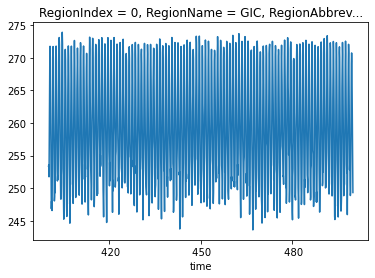

In [27]:
testout.sel(RegionIndex=0).plot()

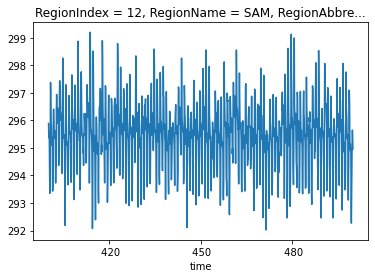

In [28]:
testout.sel(RegionIndex=12).plot()